**Chapter 3 – Relational Database and SQL**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/hanchen92/handson-ml3/blob/main/03_relational_database_and_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/hanchen92/handson-ml3/main/03_relational_database_and_sql.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
import psutil

process = psutil.Process()

# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', process.memory_info().rss/1000000000)

RAM Used (GB): 0.099979264


# Reading PostgreSQL database

In [2]:
!pip install psycopg2

In [3]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
import seaborn as sns
sns.set_theme()

# 改style要在改font之前
# plt.style.use('seaborn')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')
mpl.rcParams['figure.figsize'] = 12,6


import psycopg2
import pandas as pd
import numpy as np

--2024-09-29 14:04:19--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.132.102, 74.125.132.100, 74.125.132.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.132.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-09-29 14:04:19--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.201.132, 2607:f8b0:4001:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.201.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2024-09-29 14:04:

In [4]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `test` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS test;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE test;'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
 * Starting PostgreSQL 14 database server
   ...done.
ALTER ROLE
DROP DATABASE
CREATE DATABASE


In [5]:
#https://data.gov.tw/dataset/12197
!wget -O final_accident_110.csv "https://github.com/hanchen92/handson-ml3/raw/main/datasets/%E5%8F%B0%E4%B8%AD%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85/110%E5%B9%B4%E5%BA%A6A2%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85%E8%B3%87%E6%96%99(%E6%95%B4%E7%90%86%E5%BE%8C).csv"

--2024-09-29 14:04:43--  https://github.com/hanchen92/handson-ml3/raw/main/datasets/%E5%8F%B0%E4%B8%AD%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85/110%E5%B9%B4%E5%BA%A6A2%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85%E8%B3%87%E6%96%99(%E6%95%B4%E7%90%86%E5%BE%8C).csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/hanchen92/THU-STAT-BigData-113-1-6189/raw/main/datasets/%E5%8F%B0%E4%B8%AD%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85/110%E5%B9%B4%E5%BA%A6A2%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85%E8%B3%87%E6%96%99(%E6%95%B4%E7%90%86%E5%BE%8C).csv [following]
--2024-09-29 14:04:43--  https://github.com/hanchen92/THU-STAT-BigData-113-1-6189/raw/main/datasets/%E5%8F%B0%E4%B8%AD%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85/110%E5%B9%B4%E5%BA%A6A2%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85%E8%B3%87%E6%96%99(%E6%95%B4%E7%90%86%E5%BE%8C).csv
Reusing existing connection to github.c

In [6]:
conn = psycopg2.connect(database="test", user="postgres",
                        password="postgres", host="localhost",
                        port="5432")

In [7]:
## 允許python執行postgresql語法
with conn.cursor() as cur:

    ## 觀察查詢筆數
    print(cur.rowcount)

    ## SQL語法
    sql = """
    DROP table IF EXISTS Accident;
    CREATE TABLE Accident(
      time timestamp,
      place1 varchar(200),
      place2 varchar(200),
      city1 varchar(10),
      city2 varchar(10),
      district1 varchar(20),
      district2 varchar(20),
      road1 varchar(100),
      road2 varchar(100),
      death real,
      injury real,
      type_usage varchar(500),
      Latitude real,
      Longitude real
    )
    """

    ## 執行sql語法
    cur.execute(sql)


-1


In [8]:
## 允許python執行postgresql語法
with conn:
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      COPY Accident
      FROM '/content/final_accident_110.csv'
      DELIMITER ','
      CSV HEADER;
      """

      ## 執行sql語法
      cur.execute(sql)

conn.commit()

-1


In [9]:
## 允許python執行postgresql語法
with conn:
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      ALTER TABLE Accident
      ADD COLUMN id SERIAL PRIMARY KEY;
      """

      ## 執行sql語法
      cur.execute(sql)

conn.commit()

-1


In [10]:
## 允許python執行postgresql語法
with conn:
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      SELECT *
      FROM Accident LIMIT 20
      """

      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)


-1


In [11]:
rows

,time,place1,place2,city1,city2,district1,district2,road1,road2,death,injury,type_usage,latitude,longitude,id
0,2021-01-01 00:02:38,臺南市安平區中華西路2段口,臺南市安平區永華路2段口,臺南市,臺南市,安平區,安平區,中華西路,永華路,0.0,1.0,自用-小客車;普通重型-機車,120.187485,22.989930,1
1,2021-01-01 00:05:00,臺東縣蘭嶼鄉東80線8.6公里,None,臺東縣,None,蘭嶼鄉,None,東80線,None,0.0,1.0,普通重型-機車,121.562210,22.054365,2
2,2021-01-01 00:05:00,臺中市西屯區上安里臺灣大道三段,臺中市西屯區上安里朝富路,臺中市,臺中市,西屯區,西屯區,上安里臺灣大道,上安里朝富路,0.0,2.0,大型重型1(550C.C.以上)-機車;普通重型-機車,120.639200,24.169277,3
3,2021-01-01 00:05:20,屏東縣三地門鄉台24線21公里,None,屏東縣,None,三地門鄉,None,台24線,None,0.0,1.0,普通重型-機車;自用-小客車,120.638016,22.709900,4
4,2021-01-01 00:09:00,屏東縣新園鄉興安路與新南路口,None,屏東縣,None,新園鄉,None,興安路,新南路,0.0,1.0,普通重型-機車;自用-小客車,120.460590,22.534225,5
5,2021-01-01 00:16:00,桃園市中壢區環中東路口,桃園市中壢區新中北路口,桃園市,桃園市,中壢區,中壢區,環中東路,新中北路,0.0,4.0,普通重型-機車;普通重型-機車;乘客-人;乘客-人,121.248090,24.957088,6
6,2021-01-01 00:18:00,桃園市桃園區中山路泰昌三街口,None,桃園市,None,桃園區,None,中山路泰昌三街,None,0.0,1.0,計程車-小客車;普通重型-機車,121.293870,24.991072,7
7,2021-01-01 00:18:32,苗栗縣頭份市建國路二段85號前,None,苗栗縣,None,頭份市,None,建國路,None,0.0,1.0,自用-小客車;行人-人,120.905130,24.696833,8
8,2021-01-01 00:23:00,嘉義市東區長竹里大雅路2段,嘉義市東區長竹里潭頂路,嘉義市,嘉義市,東區,東區,長竹里大雅路,長竹里潭頂路,0.0,1.0,自用-小客車,120.478775,23.479141,9
9,2021-01-01 00:27:00,臺中市后里區附近往南約200公尺,None,臺中市,None,后里區,None,None,None,0.0,2.0,普通重型-機車;自用-小客車;乘客-人,120.685830,24.320890,10


In [12]:
import psutil

process = psutil.Process()

# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', process.memory_info().rss/1000000000)

RAM Used (GB): 0.212586496


In [13]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      SELECT *
      FROM Accident
      WHERE city1='臺中市' LIMIT 20
      """

      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)



-1


In [14]:
rows

,time,place1,place2,city1,city2,district1,district2,road1,road2,death,injury,type_usage,latitude,longitude,id
0,2021-01-01 00:05:00,臺中市西屯區上安里臺灣大道三段,臺中市西屯區上安里朝富路,臺中市,臺中市,西屯區,西屯區,上安里臺灣大道,上安里朝富路,0.0,2.0,大型重型1(550C.C.以上)-機車;普通重型-機車,120.639200,24.169277,3
1,2021-01-01 00:27:00,臺中市后里區附近往南約200公尺,None,臺中市,None,后里區,None,None,None,0.0,2.0,普通重型-機車;自用-小客車;乘客-人,120.685830,24.320890,10
2,2021-01-01 01:55:00,臺中市中區大墩里三民路二段,臺中市中區大墩里成功路,臺中市,臺中市,中區,中區,大墩里三民路,大墩里成功路,0.0,2.0,普通重型-機車;普通重型-機車,120.680290,24.143150,49
3,2021-01-01 02:00:00,臺中市大里區內新里中興路二段,臺中市大里區內新里東榮路,臺中市,臺中市,大里區,大里區,內新里中興路,內新里東榮路,0.0,1.0,普通重型-機車;自用-小客車,120.690094,24.110132,52
4,2021-01-01 02:30:00,臺中市沙鹿區公明里中清路六段,臺中市沙鹿區公明里東大路二段,臺中市,臺中市,沙鹿區,沙鹿區,公明里中清路,公明里東大路,0.0,1.0,自用-小客車;行人-人,120.614370,24.244170,63
5,2021-01-01 02:44:00,臺中市太平區宜佳里新平路二段,臺中市太平區宜佳里溪洲西路,臺中市,臺中市,太平區,太平區,宜佳里新平路,宜佳里溪洲西路,0.0,1.0,普通重型-機車;自用-小客車,120.714690,24.141455,65
6,2021-01-01 02:49:00,臺中市北區明德里漢口路三段20-1號前0.0公尺,None,臺中市,None,北區,None,明德里漢口路,None,0.0,1.0,普通重型-機車;自用-小客車,120.666725,24.166796,66
7,2021-01-01 07:40:00,臺中市北屯區和平里東山路一段481號前0.0公尺,None,臺中市,None,北屯區,None,和平里東山路,None,0.0,2.0,普通重型-機車;電動自行車-慢車,120.736900,24.178400,142
8,2021-01-01 07:40:00,臺中市梧棲區大庄里中央路一段921-2號前0.0公尺,None,臺中市,None,梧棲區,None,大庄里中央路,None,0.0,1.0,普通重型-機車;自用-小客車,120.538630,24.248459,143
9,2021-01-01 07:42:00,臺中市西屯區港尾里中清路三段150號前0.0公尺,None,臺中市,None,西屯區,None,港尾里中清路,None,0.0,1.0,普通重型-機車;普通重型-機車,120.654490,24.202020,145


In [15]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      SELECT road1,road2,count(id) as count
      FROM Accident
      WHERE city1='臺中市'
      GROUP BY road1,road2
      """

      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)



-1


In [16]:
rows.sort_values(by="count",ascending=False).head(10)

,road1,road2,count
17042,None,None,874
10416,橫山里永和路,None,88
4540,國道1號,None,86
2821,六寶里中清路,None,82
4541,國道3號,None,82
14685,路燈,None,70
4398,四德里中清路,None,68
11343,港尾里中清路,None,67
9992,栗林里中山路,None,67
16027,電桿,None,62


In [17]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      SELECT road1,road2,count(id) as count
      FROM Accident
      WHERE city1='臺中市'
      GROUP BY road1,road2
      ORDER BY count DESC LIMIT 20
      """

      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)



-1


In [18]:
rows

,road1,road2,count
0,None,None,874
1,橫山里永和路,None,88
2,國道1號,None,86
3,國道3號,None,82
4,六寶里中清路,None,82
5,路燈,None,70
6,四德里中清路,None,68
7,栗林里中山路,None,67
8,港尾里中清路,None,67
9,電桿,None,62


In [19]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      SELECT *
      FROM Accident
      WHERE city1='臺中市' AND road1 IS NULL LIMIT 20
      """

      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)



-1


In [20]:
rows

,time,place1,place2,city1,city2,district1,district2,road1,road2,death,injury,type_usage,latitude,longitude,id
0,2021-01-01 00:27:00,臺中市后里區附近往南約200公尺,None,臺中市,None,后里區,None,None,None,0.0,2.0,普通重型-機車;自用-小客車;乘客-人,120.685830,24.320890,10
1,2021-01-01 10:08:00,臺中市沙鹿區與光華路,None,臺中市,None,沙鹿區,None,None,光華路,0.0,1.0,普通重型-機車,120.564750,24.239662,263
2,2021-01-01 16:40:00,臺中市東勢區(東勢所),None,臺中市,None,東勢區,None,None,None,0.0,1.0,普通重型-機車;普通重型-機車,120.824060,24.258540,628
3,2021-01-01 16:50:00,臺中市沙鹿區口,None,臺中市,None,沙鹿區,None,None,None,0.0,1.0,普通重型-機車;普通重型-機車,120.604920,24.243652,642
4,2021-01-01 17:45:00,臺中市清水區與西社橋旁,None,臺中市,None,清水區,None,None,西社橋,0.0,2.0,普通重型-機車;普通重型-機車,120.563550,24.278873,704
5,2021-01-01 18:08:00,臺中市西屯區榮總急診對面,None,臺中市,None,西屯區,None,None,None,0.0,1.0,自用-小客車;自用-小客車;乘客-人,120.602160,24.185349,727
6,2021-01-01 19:49:00,臺中市豐原區、東北街,None,臺中市,None,豐原區,None,None,東北街,0.0,1.0,自用-小客車;普通重型-機車,120.713390,24.251644,813
7,2021-01-01 20:21:00,臺中市南屯區與龍富路四段(口),None,臺中市,None,南屯區,None,None,龍富路,0.0,2.0,自用-小客車;普通重型-機車;乘客-人,120.625690,24.141169,830
8,2021-01-01 21:43:00,臺中市西區與向上北路189巷口,None,臺中市,None,西區,None,None,向上北路,0.0,3.0,普通重型-機車;普通重型-機車;乘客-人,120.660934,24.147284,869
9,2021-01-01 22:40:00,臺中市潭子區與人和路37巷,None,臺中市,None,潭子區,None,None,人和路,0.0,1.0,普通重型-機車;普通重型-機車,120.707390,24.216970,898


In [21]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      SELECT road1,road2,count(id) as count
      FROM Accident
      WHERE city1='臺中市' AND road1 IS NOT NULL AND road2 IS NOT NULL
      GROUP BY road1,road2
      ORDER BY count DESC LIMIT 20
      """

      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)



-1


In [22]:
rows

,road1,road2,count
0,惠來里臺灣大道,惠來里文心路,20
1,忠明里臺灣大道,忠明里中興街,19
2,五光里五光路,五光里五光路,18
3,樹德里文心南路,樹德里建國北路,18
4,西平里華夏巷,西平里華夏巷,17
5,六路里臺灣大道,六路里正英路,17
6,溪壩里溪南路,溪壩里溪南路,16
7,竹林里臺灣大道,竹林里中山路,16
8,惠來里臺灣大道,惠來里惠中路,16
9,新興里雙十路,新興里精武路,16


In [23]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      WITH Accident2 AS(
        SELECT *, date_trunc('hour', time) as time_hour
        FROM Accident WHERE city1='臺中市'
      )
      SELECT time_hour,count(id) as count
      FROM Accident2
      GROUP BY time_hour
      ORDER BY time_hour
      """

      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)



-1


<Axes: xlabel='time_hour', ylabel='count'>

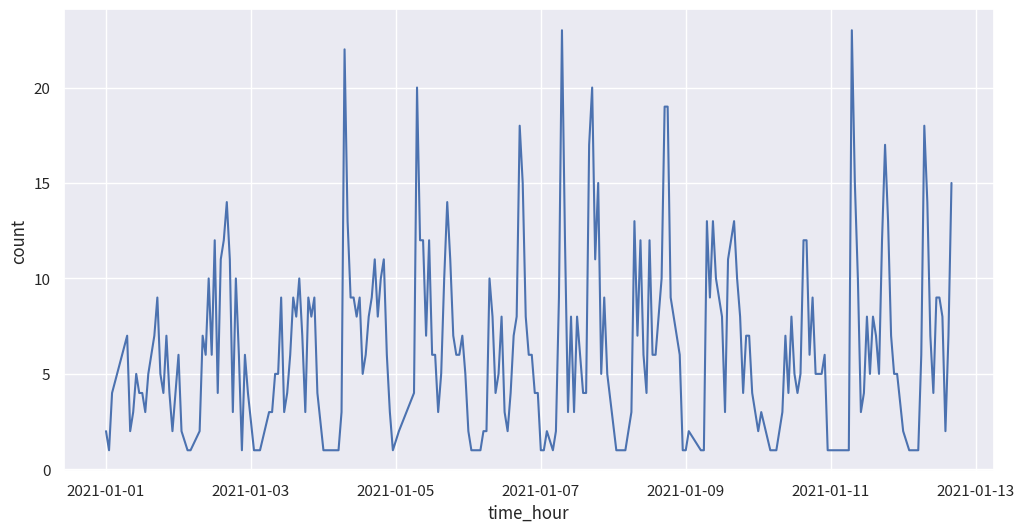

In [24]:
sns.lineplot(data=rows.iloc[:(24*10),:], x="time_hour", y="count")

In [25]:
#https://data.gov.tw/dataset/8410
!wget -O population_110.csv "https://raw.githubusercontent.com/hanchen92/handson-ml3/main/datasets/%E5%8F%B0%E4%B8%AD%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85/110%E5%90%84%E9%84%89%E9%8E%AE%E5%B8%82%E5%8D%80%E4%BA%BA%E5%8F%A3%E5%AF%86%E5%BA%A6.csv"

--2024-09-29 14:04:55--  https://raw.githubusercontent.com/hanchen92/handson-ml3/main/datasets/%E5%8F%B0%E4%B8%AD%E4%BA%A4%E9%80%9A%E4%BA%8B%E6%95%85/110%E5%90%84%E9%84%89%E9%8E%AE%E5%B8%82%E5%8D%80%E4%BA%BA%E5%8F%A3%E5%AF%86%E5%BA%A6.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15227 (15K) [text/plain]
Saving to: ‘population_110.csv’

population_110.csv  100%[===================>]  14.87K  --.-KB/s    in 0.001s  

2024-09-29 14:04:55 (20.8 MB/s) - ‘population_110.csv’ saved [15227/15227]



In [26]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      DROP table IF EXISTS Population;
      CREATE TABLE Population(
        year real,
        city_district varchar(200),
        population real,
        area real,
        density real
      );
      COPY Population
      FROM '/content/population_110.csv'
      DELIMITER ','
      CSV HEADER;
      """

      ## 執行sql語法
      cur.execute(sql)


-1


In [27]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      SELECT * from Population
      """

      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)



-1


In [28]:
rows.head(5)

,year,city_district,population,area,density
0,110.0,新北市板橋區,552713.0,23.1373,23888.0
1,110.0,新北市三重區,381731.0,16.3170,23395.0
2,110.0,新北市中和區,406140.0,20.1440,20162.0
3,110.0,新北市永和區,214967.0,5.7138,37622.0
4,110.0,新北市新莊區,421381.0,19.7383,21348.0


In [29]:
with conn:
  ## 允許python執行postgresql語法
  with conn.cursor() as cur:

      ## 觀察查詢筆數
      print(cur.rowcount)

      ## SQL語法
      sql = """
      WITH Accident2 AS(
        SELECT *, concat(city1,district1) AS city_district
        FROM Accident
      ),
      Accident3 AS(
        SELECT city_district, count(id) AS count
        FROM Accident2 GROUP BY city_district
      )
      SELECT t1.city_district AS city_district, population, area, density, count
      FROM Accident3 t1 LEFT JOIN Population t2 ON t1.city_district=t2.city_district
      """


      ## 執行sql語法
      cur.execute(sql)
      ## 取得欄位名稱
      name = [desc[0] for desc in cur.description]

      ## 取得資料
      rows = pd.DataFrame(cur.fetchall(),columns=name)



-1


In [30]:
rows.head(5)

,city_district,population,area,density,count
0,南投縣中寮鄉,14013.0,146.6541,96.0,83
1,南投縣仁愛鄉,15810.0,1273.5312,12.0,286
2,南投縣信義鄉,15785.0,1422.4188,11.0,60
3,南投縣南投市,98244.0,71.6021,1372.0,1836
4,南投縣名間鄉,36925.0,83.0955,444.0,428


<ipython-input-31-ff32f10042be>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right');


[Text(0, 0.5, '車禍發生次數')]

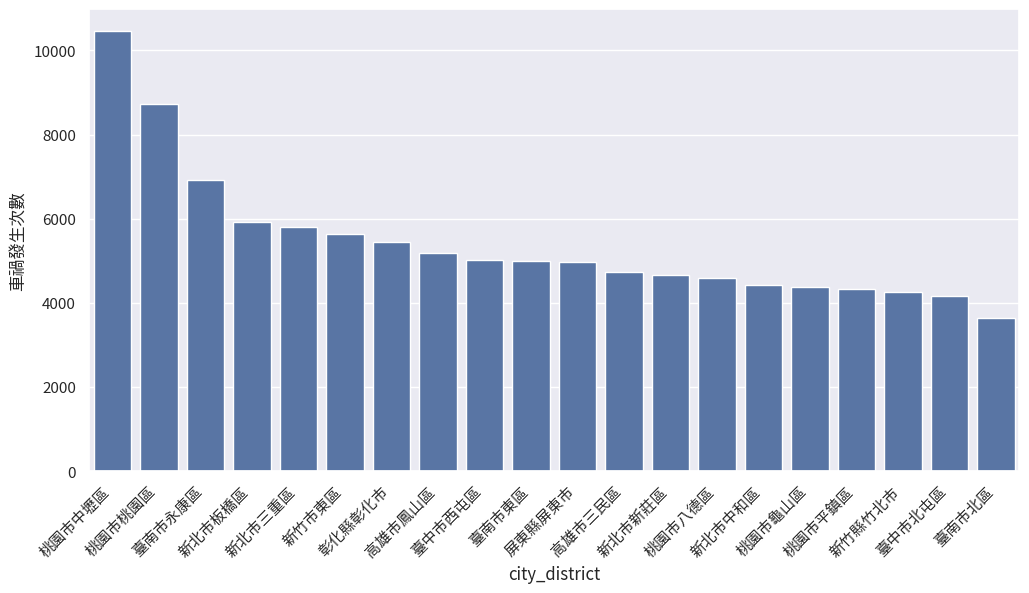

In [31]:
rows1=rows.sort_values(by="count",ascending=False).head(20).loc[:,["city_district","count"]].reset_index(drop=True)
my_plot = sns.barplot(data=rows1, x="city_district", y="count")
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right');
my_plot.set(ylabel='車禍發生次數')

[Text(0, 0.5, '車禍發生次數'), Text(0.5, 0, '人口')]

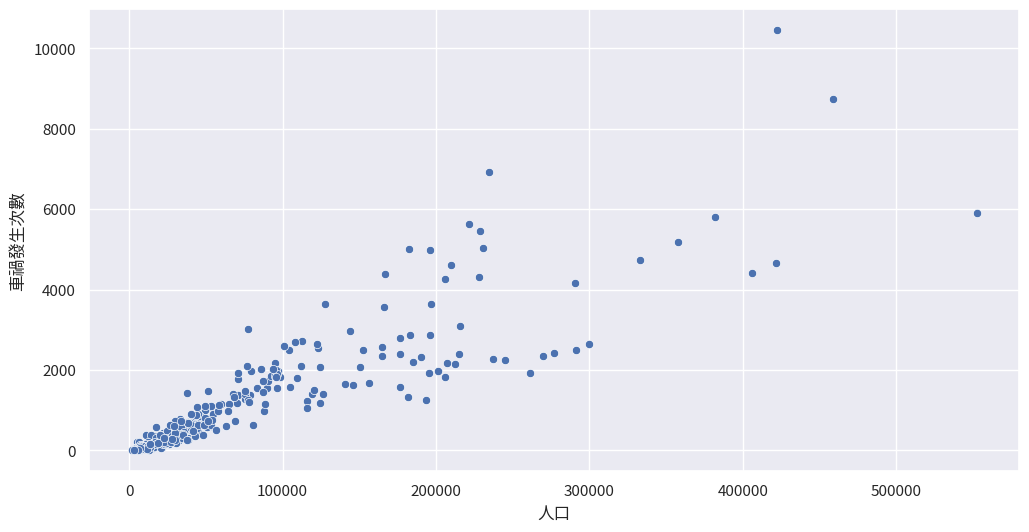

In [32]:

#plt.plot(rows["population"],rows["count"],'o')
my_plot = sns.scatterplot(rows,x="population",y="count")
my_plot.set(ylabel='車禍發生次數',xlabel="人口")
#plt.plot(np.log(rows["population"]),np.log(rows["count"]),'o')

In [33]:

rows.sort_values(by="count",ascending=False).head(20)

,city_district,population,area,density,count
156,桃園市中壢區,422529.0,76.5200,5522.0,10452
163,桃園市桃園區,458847.0,34.8046,13184.0,8730
245,臺南市永康區,234624.0,40.2753,5826.0,6921
122,新北市板橋區,552713.0,23.1373,23888.0,5913
113,新北市三重區,381731.0,16.3170,23395.0,5806
141,新竹市東區,221651.0,33.5768,6601.0,5636
96,彰化縣彰化市,228470.0,65.6947,3478.0,5460
363,高雄市鳳山區,357946.0,26.7590,13377.0,5185
200,臺中市西屯區,230888.0,39.8467,5794.0,5030
240,臺南市東區,182489.0,13.4156,13603.0,5006


In [34]:
rows.corr(numeric_only=True)

,population,area,density,count
population,1.000000,-0.197011,0.648255,0.896281
area,-0.197011,1.000000,-0.210497,-0.191789
density,0.648255,-0.210497,1.000000,0.527212
count,0.896281,-0.191789,0.527212,1.000000


In [35]:
rows["count_per_population"] = rows["count"]/rows["population"]
rows.sort_values(by="count_per_population",ascending=False).head(20)

,city_district,population,area,density,count,count_per_population
66,屏東縣枋山鄉,5150.0,17.2697,298.0,218,0.042330
218,臺南市中西區,77704.0,6.2600,12413.0,3027,0.038956
238,臺南市新市區,37546.0,47.8096,785.0,1433,0.038167
84,屏東縣麟洛鄉,10629.0,16.2600,654.0,376,0.035375
175,臺中市中區,17689.0,0.8803,20094.0,589,0.033298
118,新北市坪林區,6619.0,170.8350,39.0,215,0.032482
245,臺南市永康區,234624.0,40.2753,5826.0,6921,0.029498
226,臺南市善化區,51265.0,55.3097,927.0,1484,0.028948
222,臺南市北區,127913.0,10.4340,12259.0,3649,0.028527
219,臺南市仁德區,76497.0,50.7664,1507.0,2109,0.027570


<ipython-input-36-1b2846d117cc>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right');


[Text(0, 0.5, '車禍發生次數/人口'), Text(0.5, 0, '')]

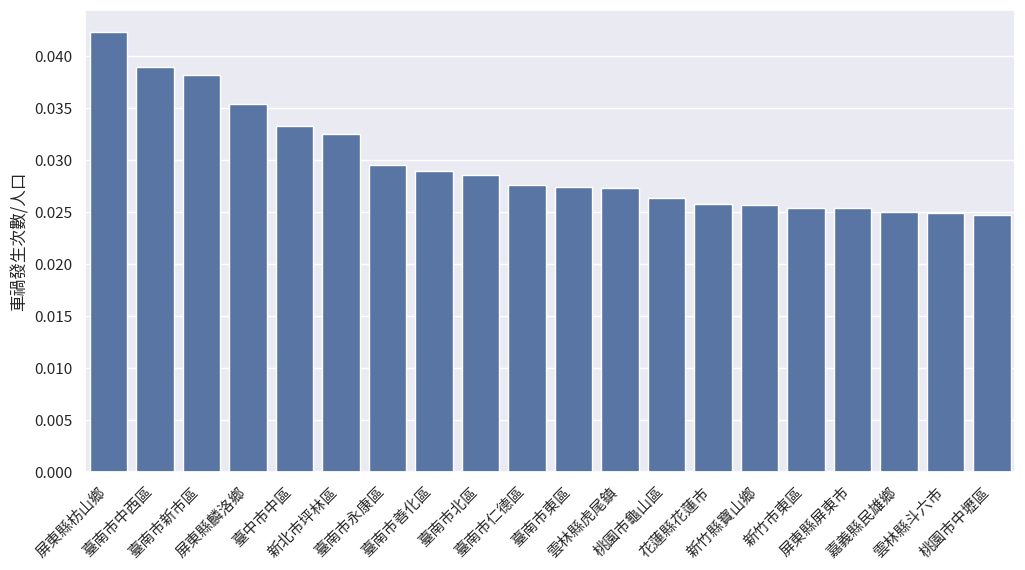

In [36]:
rows1=rows.sort_values(by="count_per_population",ascending=False).head(20).loc[:,["city_district","count_per_population"]].reset_index(drop=True)
my_plot = sns.barplot(data=rows1, x="city_district", y="count_per_population")
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right');
my_plot.set(ylabel='車禍發生次數/人口',xlabel="")

In [37]:
#rows.head(5).to_csv("/content/tmp.csv",encoding="utf-8-sig")

In [38]:
import psutil

process = psutil.Process()

# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', process.memory_info().rss/1000000000)

RAM Used (GB): 0.242454528


################################################################################

# Pandas

In [39]:
%reset -sf

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
import seaborn as sns
sns.set_theme()

# 改style要在改font之前
# plt.style.use('seaborn')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')
mpl.rcParams['figure.figsize'] = 12,6


import pandas as pd
import numpy as np

In [41]:
data = pd.read_csv("final_accident_110.csv")
data["time"] = pd.to_datetime(data["time"])

In [42]:
import psutil

process = psutil.Process()

# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', process.memory_info().rss/1000000000)

RAM Used (GB): 0.417787904


In [43]:
# same as where
data.query("city1=='臺中市'")

,time,place1,place2,city1,city2,district1,district2,road1,road2,death,injury,type_usage,latitude,longitude
2,2021-01-01 00:05:00+00:00,臺中市西屯區上安里臺灣大道三段,臺中市西屯區上安里朝富路,臺中市,臺中市,西屯區,西屯區,上安里臺灣大道,上安里朝富路,0.0,2.0,大型重型1(550C.C.以上)-機車;普通重型-機車,120.639200,24.169277
9,2021-01-01 00:27:00+00:00,臺中市后里區附近往南約200公尺,NaN,臺中市,NaN,后里區,NaN,NaN,NaN,0.0,2.0,普通重型-機車;自用-小客車;乘客-人,120.685830,24.320890
48,2021-01-01 01:55:00+00:00,臺中市中區大墩里三民路二段,臺中市中區大墩里成功路,臺中市,臺中市,中區,中區,大墩里三民路,大墩里成功路,0.0,2.0,普通重型-機車;普通重型-機車,120.680290,24.143150
51,2021-01-01 02:00:00+00:00,臺中市大里區內新里中興路二段,臺中市大里區內新里東榮路,臺中市,臺中市,大里區,大里區,內新里中興路,內新里東榮路,0.0,1.0,普通重型-機車;自用-小客車,120.690094,24.110132
62,2021-01-01 02:30:00+00:00,臺中市沙鹿區公明里中清路六段,臺中市沙鹿區公明里東大路二段,臺中市,臺中市,沙鹿區,沙鹿區,公明里中清路,公明里東大路,0.0,1.0,自用-小客車;行人-人,120.614370,24.244170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356395,2021-12-31 23:12:00+00:00,臺中市龍井區新庄里中?路前0.0公尺,NaN,臺中市,NaN,龍井區,NaN,新庄里中?路,NaN,0.0,1.0,自用-小客車;自用-小客車;乘客-人,120.575040,24.190025
356399,2021-12-31 23:19:00+00:00,臺中市西屯區永安里西屯路三段166-27號前0.0公尺,NaN,臺中市,NaN,西屯區,NaN,永安里西屯路,NaN,0.0,1.0,自用-小客車;普通重型-機車,120.616170,24.188990
356405,2021-12-31 23:31:00+00:00,臺中市西屯區西平里逢甲路66號前0.0公尺,NaN,臺中市,NaN,西屯區,NaN,西平里逢甲路,NaN,0.0,1.0,普通重型-機車;普通重型-機車,120.644290,24.178900
356410,2021-12-31 23:53:00+00:00,臺中市西屯區何厝里臺灣大道二段908號前0.0公尺,NaN,臺中市,NaN,西屯區,NaN,何厝里臺灣大道,NaN,0.0,1.0,普通重型-機車;自用-小客車,120.651720,24.161718


In [44]:
data1 = data.copy()
data1["index"] = range(data1.shape[0])
data1.fillna('', inplace=True)
# same as where
data1.query("city1=='臺中市'").groupby(["road1","road2"])["index"].count().reset_index(name="count").sort_values(by="count",ascending=False).head(20)

,road1,road2,count
0,,,874
10885,橫山里永和路,,88
5166,國道1號,,86
5167,國道3號,,82
3444,六寶里中清路,,82
15143,路燈,,70
5017,四德里中清路,,68
11809,港尾里中清路,,67
10504,栗林里中山路,,67
4975,員林里神林路,,62


In [45]:
data1.query("city1=='臺中市' & road1!='' & road2!=''").groupby(["road1","road2"])["index"].count().reset_index(name="count").sort_values(by="count",ascending=False).head(20)

,road1,road2,count
4884,惠來里臺灣大道,惠來里文心路,20
4682,忠明里臺灣大道,忠明里中興街,19
6594,樹德里文心南路,樹德里建國北路,18
887,五光里五光路,五光里五光路,18
9063,西平里華夏巷,西平里華夏巷,17
1773,六路里臺灣大道,六路里正英路,17
5355,新東里新興路,新東里新興路,16
5499,新興里雙十路,新興里精武路,16
8394,竹林里臺灣大道,竹林里中山路,16
7431,溪壩里溪南路,溪壩里溪南路,16


<Axes: xlabel='time_hour', ylabel='count'>

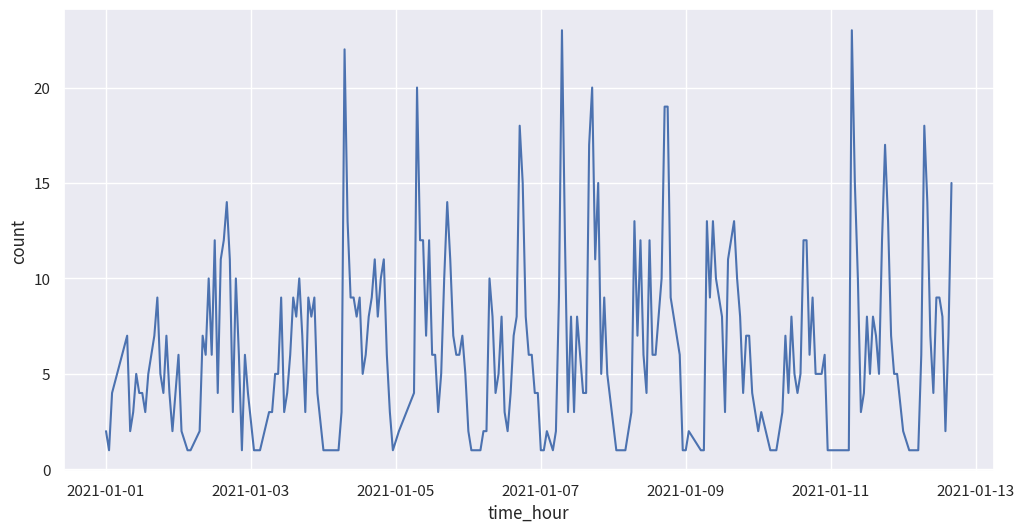

In [46]:
data1["time_hour"] = data1["time"].dt.floor('H')
data1_count_by_hour = data1.query("city1=='臺中市'").groupby(["time_hour"])["index"].count().reset_index(name="count").sort_values(by="time_hour")
sns.lineplot(data=data1_count_by_hour.iloc[:(24*10),:], x="time_hour", y="count")

<ipython-input-47-d72d69b6311c>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right');


[Text(0, 0.5, '車禍發生次數'), Text(0.5, 0, '')]

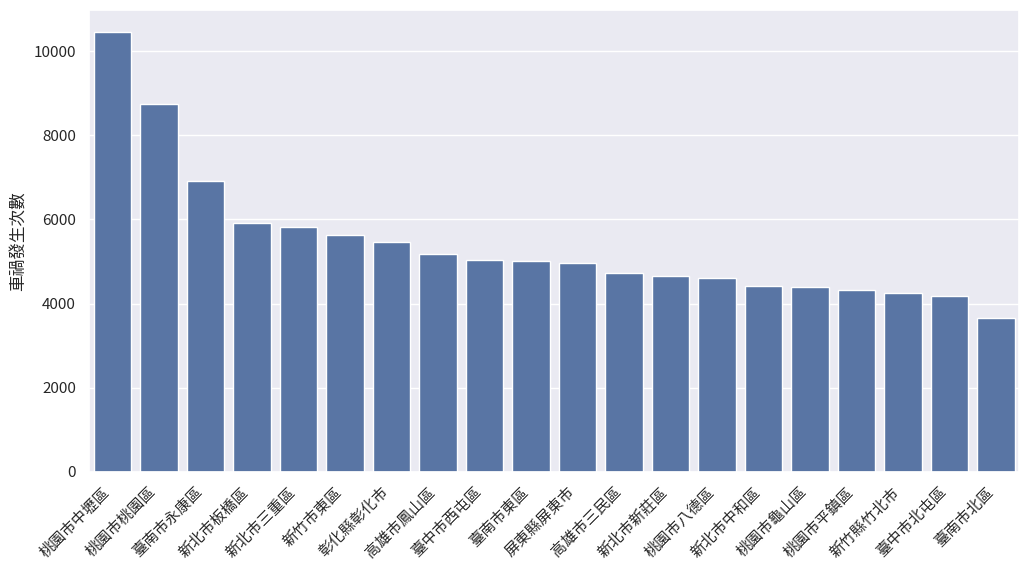

In [47]:
data1["city_district"] = data1["city1"] + data1["district1"]
data1_count_by_district = data1.groupby(["city_district"])["index"].count().reset_index(name="count").sort_values(by="count",ascending=False)
my_plot = sns.barplot(data=data1_count_by_district.head(20), x="city_district", y="count")
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right');
my_plot.set(ylabel='車禍發生次數',xlabel="")

<ipython-input-48-35a55c750acc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right');


[Text(0, 0.5, '車禍發生次數/人口'), Text(0.5, 0, '')]

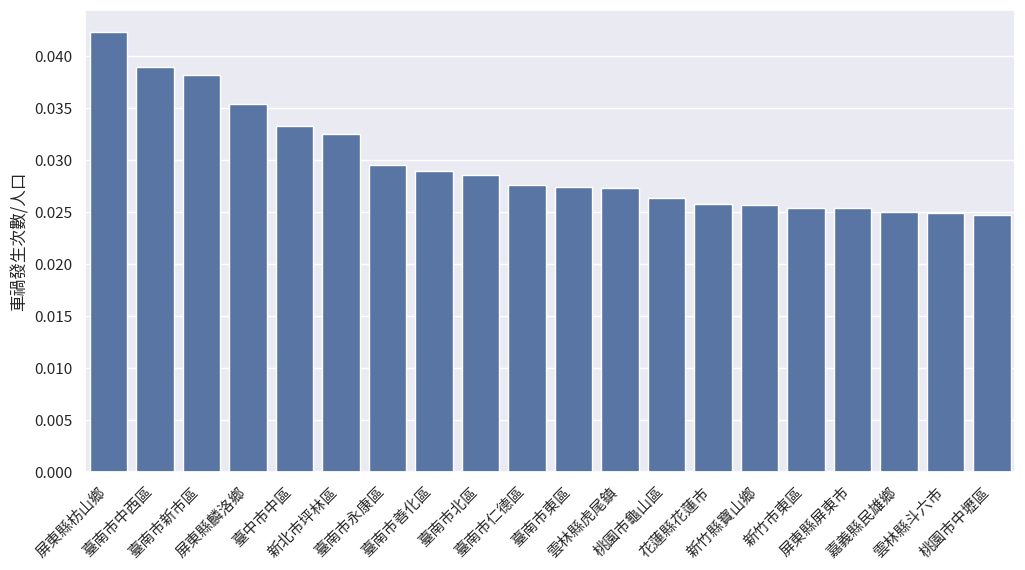

In [48]:
data_population = pd.read_csv("population_110.csv")
data_count_population_merge = data1_count_by_district.merge(data_population,how="left",left_on="city_district", right_on="區域別")

data_count_population_merge["count_per_population"] = data_count_population_merge["count"]/data_count_population_merge["年底人口數"]
data_count_population_merge2 = data_count_population_merge.sort_values(by="count_per_population",ascending=False)


my_plot = sns.barplot(data=data_count_population_merge2.head(20), x="city_district", y="count_per_population")
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right');
my_plot.set(ylabel='車禍發生次數/人口',xlabel="")

In [49]:
data_count_population_merge2

,city_district,count,統計年,區域別,年底人口數,土地面積,人口密度,count_per_population
231,屏東縣枋山鄉,218,110,屏東縣枋山鄉,5150,17.2697,298,0.042330
23,臺南市中西區,3027,110,臺南市中西區,77704,6.2600,12413,0.038956
85,臺南市新市區,1433,110,臺南市新市區,37546,47.8096,785,0.038167
187,屏東縣麟洛鄉,376,110,屏東縣麟洛鄉,10629,16.2600,654,0.035375
157,臺中市中區,589,110,臺中市中區,17689,0.8803,20094,0.033298
...,...,...,...,...,...,...,...,...
360,苗栗縣泰安鄉,5,110,苗栗縣泰安鄉,5691,614.5127,9,0.000879
361,澎湖縣七美鄉,3,110,澎湖縣七美鄉,3862,6.9868,553,0.000777
365,連江縣東引鄉,1,110,連江縣東引鄉,1494,3.8000,393,0.000669
362,澎湖縣望安鄉,3,110,澎湖縣望安鄉,5415,13.7824,393,0.000554


In [50]:
data_count_population_merge.sort_values(by="count_per_population",ascending=True).head(20)

,city_district,count,統計年,區域別,年底人口數,土地面積,人口密度,count_per_population
364,高雄市那瑪夏區,1,110,高雄市那瑪夏區,3143,252.9895,12,0.000318
362,澎湖縣望安鄉,3,110,澎湖縣望安鄉,5415,13.7824,393,0.000554
365,連江縣東引鄉,1,110,連江縣東引鄉,1494,3.8000,393,0.000669
361,澎湖縣七美鄉,3,110,澎湖縣七美鄉,3862,6.9868,553,0.000777
360,苗栗縣泰安鄉,5,110,苗栗縣泰安鄉,5691,614.5127,9,0.000879
354,金門縣烈嶼鄉,12,110,金門縣烈嶼鄉,12743,16.0030,796,0.000942
363,高雄市茂林區,2,110,高雄市茂林區,1874,194.0000,10,0.001067
352,屏東縣來義鄉,13,110,屏東縣來義鄉,7397,167.7756,44,0.001757
347,臺中市和平區,20,110,臺中市和平區,10870,1037.8192,10,0.001840
356,屏東縣泰武鄉,10,110,屏東縣泰武鄉,5360,118.6266,45,0.001866


In [51]:
import psutil

process = psutil.Process()

# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', process.memory_info().rss/1000000000)

RAM Used (GB): 0.51881984
